<a href="https://colab.research.google.com/github/nidhin-koshy/Notebooks/blob/master/DecisionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Calssifier

A decision tree classifier partitions the feature space in a hierarchical manner and assigns class labels to each partition. The partition rules are along the different feature axes and hence we can provide a descriptive and intuitive classification rule for each partition. The key part of the algorithm is the way in which the partitioning is done.

    Decision Tree Algorithm: For a a given set of samples and labels, a split finds the best feature and a partioning that reduces the class entropy (or gini index). This provides us with two sets of samples and labels. The above procedure is repeated on each generated set of samples and labels till the max_depth of the tree is reached.

### Import required modules/libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Define required functions

In [0]:
#Define a class for a node in the tree
class Tree(object):
    def __init__(self):
        self.split=False # Is this node further split?
        self.parent=None # Which is the parent node of the node
        self.depth=0 #At what depth is this node
        self.is_left=False #Is this a left node of the parent node?
        self.left = None #The left child node of this node
        self.right = None #The right child node of this node
        #self.data = None 
        self.feature = None #The feature used for the split in this node
        self.threshold = None #The threshold used for the split on the above feature
        self.entropy_before_split=None #entropy before the split
        self.entropy_after_split=None #entropy after the split
        self.num_labels=[] #number of instances of different labels
        self.total_labels=0 #total number of labels

In [0]:
#Define a function to compute the entropy of the frequency of the labels
def entropy(labels):
  total_labels = len(labels)
  unique_labels = list(set(labels)) #find the different unique labels present in labels
  num_labels=np.array([])
  for label in unique_labels:
    num_labels = np.append(num_labels,len(labels[labels==label])) #find the number of instances of each label
  num_labels_pmf=num_labels/total_labels #normalize the number of instances of each label
  log_num_labels_pmf = np.log2(num_labels_pmf) #compute the log2() of the normalized num labels
  entropy_var= sum(-num_labels_pmf*log_num_labels_pmf) #compute the entropy as: sum_i -pi*log(pi)
  return [entropy_var,num_labels,total_labels]

In [0]:
#Define a function to compute the entropy when the labels are split into two partitions.
#The resulting entropy is the weighted average of the two partitions, each weighted by its fractions of samples.
def entropy_split(labels_split):
  total_labels = 0
  num_labels=np.array([])
  entropy_labels=np.array([])
  for item in labels_split: #iterate over the partitions
    total_labels+=len(item) #compute the total number of samples
    num_labels=np.append(num_labels,len(item)) #compute the number of labels in each partition
    entropy_labels=np.append(entropy_labels,entropy(item)[0]) #compute the entropy for each partition
  num_labels = num_labels/total_labels #make it a pmf
  entropy_split_var = sum(num_labels*entropy_labels) #compute the weighted entropy
  return entropy_split_var

In [0]:
#Define a function that optimally splits a set of samples depending on the given feature such that the resulting entropy is minimized
def split_samples_feature(samples,labels,feature):
  num_points = 100 #The search for the optimal threshold is restricted to 100 equally spaced points between the min and max
  min_feature=min(samples[:,feature]) #the minimum value observed for the feature
  max_feature=max(samples[:,feature]) #the maximum value observed for the feature
  thresholds = np.linspace(min_feature,max_feature,num_points) #obtain the candidate thresholds (equally spaced values between min and max)
  curr_entropy = entropy(labels)[0] #initialize entropy to that of the combined labels (entropy of any split will be less than this value)
  curr_threshold = thresholds[0] #initialize the threshold to the min value
  for threshold in thresholds: #iterate over the thresholds
    labels_1=labels[samples[:,feature]<=threshold] # obtain the first partition based on the candidate threshold
    labels_2=labels[samples[:,feature]>threshold]  # obtain the second partition based on the candidate threshold
    labels_split = [labels_1,labels_2] # collect the two partitions
    new_entropy = entropy_split(labels_split) #compute the entropy of the new split
    if(new_entropy < curr_entropy):#compare the entropy for the new split with best entropy so far. If the new entropy is smaller than the best so far, update the values
      curr_entropy = new_entropy # update the best entropy
      curr_threshold = threshold # update the best threshold
    labels_1=labels[samples[:,feature]<=curr_threshold] # labels partition 1 of the best split
    labels_2=labels[samples[:,feature]>curr_threshold] # labels partition 2 of the best split
    samples_1=samples[samples[:,feature]<=curr_threshold,:] # sample partition 1 of the best split
    samples_2=samples[samples[:,feature]>curr_threshold,:] # sample partition 2 of the best split
  return [curr_threshold,curr_entropy,labels_1,labels_2,samples_1,samples_2] 

In [0]:
# Define a function the splits a given set of samples based on best feature that minimizes the entropy
def split_samples(samples,labels,parent_node,max_depth,curr_depth):
  curr_threshold=float('inf') #initialize best threshold to an arbitrary value
  [curr_entropy,num_labels,total_labels] = entropy(labels) #obtain the entropy, number of labels in each class and the total number of labels/samples
  parent_node.entropy_before_split=curr_entropy # store the entropy of the current set of samples before splitting in the node class. This is just for information afterwards when analysing the tree.
  parent_node.num_labels=num_labels # store the number of labels in the node class
  parent_node.total_labels=total_labels # store the total number of labels in the node class
  curr_feature = 0
  found_split = False #initialize the boolean to false. This will be set to True when a split that minimizes entropy is found
  for feature in range(samples.shape[1]): #iterate over features
    [new_threshold,new_entropy,labels_1,labels_2,samples_1,samples_2] = split_samples_feature(samples,labels,feature) # find the best split for this feature
    if(new_entropy < curr_entropy): #if the new feature is better
      found_split=True 
      curr_feature = feature
      curr_entropy=new_entropy
      curr_threshold = new_threshold
      curr_labels_1=labels_1
      curr_labels_2=labels_2
      curr_samples_1=samples_1
      curr_samples_2=samples_2
  parent_node.split=found_split
  parent_node.depth=curr_depth
  if found_split : #once the best feature is obtained, populate the node class with the relevant information
    parent_node.feature=curr_feature # store the best feature to split at the current node
    parent_node.entropy_after_split=curr_entropy #store the entropy after the split. This should be less than the entropy before split
    parent_node.threshold=curr_threshold # store the threshold at which to split
    if(curr_depth<max_depth): # if the depth of the current node is less than the max_depth, then continue the splitting process
      node_left=Tree() #initialize a new node to be attached to the left of the current node.
      node_right=Tree() #similarly, initialize a new node to be attached to the right of the current node
      parent_node.left=node_left #link the parent node to the child nodes
      parent_node.right=node_right
      node_left.parent=parent_node #link the child nodes to the parent node
      node_left.is_left=True # store whether the child node is a left node or a right node
      node_right.parent=parent_node
      node_right.is_left=False
      split_samples(curr_samples_1,curr_labels_1,node_left,max_depth,curr_depth+1) #call a recursion on the same function with the new set of samples corresponding to the left partition
      split_samples(curr_samples_2,curr_labels_2,node_right,max_depth,curr_depth+1) #similarly for the right partition

In [0]:
# Define a function to print the relevant information of the final decision tree
def print_tree(root):
  print("Node level = ", root.depth,". Is left = ",root.is_left,". Node Entropy before split = ",root.entropy_before_split,". Node Entropy after split = ",root.entropy_after_split)
  print("\t Node feature = ", root.feature,". Node threshold = ", root.threshold)
  print("\t Num labels = ", root.num_labels,". Total number of labels = ", root.total_labels)
  if(root.left): print_tree(root.left) # a recursion on the child nodes
  if(root.right): print_tree(root.right)
    
    
    
    

In [0]:
# Main code body
from sklearn.datasets import load_wine  # Load in-built dataset on classification of wines
data = load_wine()
samples=data['data'] # obtain the samples
labels=data['target'] # obtain the labels
curr_depth=0 # the depth of the root node is initialized to 0
max_depth=2  # specify the maximum depth to which the tree can grow
root = Tree() #initialize the root node
split_samples(samples,labels,root,max_depth,curr_depth) # Call the main function that computes the decision tree


In [164]:
print_tree(root)

Node level =  0 . Is left =  False . Node Entropy before split =  1.5668222768551812 . Node Entropy after split =  0.9260146995661807
	 Node feature =  6 . Node threshold =  1.584848484848485
	 Num labels =  [59. 71. 48.] . Total number of labels =  178
Node level =  1 . Is left =  True . Node Entropy before split =  0.7918583525674836 . Node Entropy after split =  0.11178702106396361
	 Node feature =  9 . Node threshold =  3.847474747474748
	 Num labels =  [15. 48.] . Total number of labels =  63
Node level =  2 . Is left =  True . Node Entropy before split =  0.0 . Node Entropy after split =  None
	 Node feature =  None . Node threshold =  None
	 Num labels =  [14.] . Total number of labels =  14
Node level =  2 . Is left =  False . Node Entropy before split =  0.14372616993938178 . Node Entropy after split =  0.0
	 Node feature =  2 . Node threshold =  2.02
	 Num labels =  [ 1. 48.] . Total number of labels =  49
Node level =  1 . Is left =  False . Node Entropy before split =  0.99

## Use scikit-learn's in-built implementation of decision trees

[Text(167.4, 181.2, 'X[6] <= 1.575\nentropy = 1.567\nsamples = 178\nvalue = [59, 71, 48]'),
 Text(83.7, 108.72, 'X[9] <= 3.825\nentropy = 0.771\nsamples = 62\nvalue = [0, 14, 48]'),
 Text(41.85, 36.23999999999998, 'entropy = 0.0\nsamples = 13\nvalue = [0, 13, 0]'),
 Text(125.55000000000001, 36.23999999999998, 'entropy = 0.144\nsamples = 49\nvalue = [0, 1, 48]'),
 Text(251.10000000000002, 108.72, 'X[12] <= 724.5\nentropy = 1.0\nsamples = 116\nvalue = [59, 57, 0]'),
 Text(209.25, 36.23999999999998, 'entropy = 0.133\nsamples = 54\nvalue = [1, 53, 0]'),
 Text(292.95, 36.23999999999998, 'entropy = 0.345\nsamples = 62\nvalue = [58, 4, 0]')]

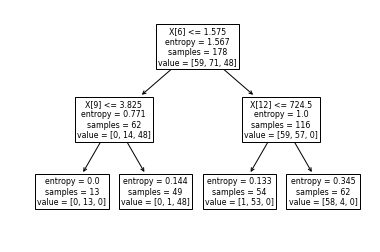

In [163]:
#We will verify our implementation of the decision tree using the in-built implementation of decision tree in scikit learn
from sklearn.datasets import load_wine
from sklearn import tree
data = load_wine()
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=2)
clf = clf.fit(data.data, data.target)
tree.plot_tree(clf.fit(data.data, data.target)) 

# Exercises
* Make changes so that the decision tree is based on minimizing the gini index (replace entropy with gini index).
* Verify your implementation using the scikit-learn implementation of the decision tree, with the criterion set to gini.